In [ ]:
!pip install -q transformers datasets evaluate sentencepiece scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dataset_test3.jsonl to dataset_test3.jsonl
Saving final_model.zip to final_model.zip


In [ ]:
import zipfile
import os

zip_path = "final_model.zip"
extract_path = "./final_model"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Contenu du dossier final_model :", os.listdir(extract_path))

Contenu du dossier final_model : ['special_tokens_map.json', 'tokenizer_config.json', 'sentencepiece.bpe.model', 'model.safetensors', 'config.json', 'added_tokens.json']


In [ ]:
import pandas as pd
from datasets import Dataset

df = pd.read_json("dataset_test3.jsonl", lines=True)
ds = Dataset.from_pandas(df)

# 🔢 Conversion label texte → entier
label2id = {"non_incident": 0, "incident": 1}
def encode_labels(example):
    example["label"] = label2id[example["label"]]
    return example

ds = ds.map(encode_labels)

Map:   0%|          | 0/606 [00:00<?, ? examples/s]

In [ ]:
from transformers import CamembertTokenizer, CamembertForSequenceClassification

tokenizer = CamembertTokenizer.from_pretrained(extract_path)
model = CamembertForSequenceClassification.from_pretrained(extract_path)

def tokenize_function(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

tokenized_ds = ds.map(tokenize_function, batched=True)

Map:   0%|          | 0/606 [00:00<?, ? examples/s]

In [ ]:
from transformers import Trainer, TrainingArguments
import torch
import numpy as np
from scipy.special import softmax

trainer = Trainer(
    model=model,
    args=TrainingArguments(output_dir="./results_eval", report_to="none"),
)
raw_pred = trainer.predict(tokenized_ds)
logits = raw_pred.predictions
probas = softmax(logits, axis=1)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [ ]:
TRIP_TYPES_RISQUES = [
    "Retour à domicile",
    "Transfert vers un autre établissement",
    "Consultation, examen... Aller - Retour",
    "Consultation externe - Aller Retour",
    "CS, examens externes (Rx, ...)"
]


TIME_TYPES_RISQUES = [
    "Rendez-vous", "Immédiat"
]


In [ ]:
from datetime import datetime

y_true = raw_pred.label_ids
y_proba_incident = probas[:, 1]
y_pred = []
false_negatives = []

SEUIL_STANDARD = 0.5
SEUIL_MIN = 0.3  # seuil plancher
REDUCTION = 0.05  # réduction par paramètre à risque

for idx, proba in enumerate(y_proba_incident):
    row = ds[idx]
    seuil = SEUIL_STANDARD

    # 🔹 Réduction progressive par critère à risque
    if row["trip_type"] in TRIP_TYPES_RISQUES:
        seuil -= REDUCTION
    if row["time_type"] in TIME_TYPES_RISQUES:
        seuil -= REDUCTION
    if row["is_weekend"]:
        seuil -= REDUCTION
    if row["is_bank_holidays"]:
        seuil -= REDUCTION

    # 🔹 Ajustement selon les heures des messages
    try:
        dt_starting = datetime.strptime(row["dt_starting"], "%Y-%m-%d %H:%M:%S")
        first_msg_dt = datetime.strptime(row["first_message_dt"], "%Y-%m-%d %H:%M:%S")
        latest_msg_dt = datetime.strptime(row["latest_message_dt"], "%Y-%m-%d %H:%M:%S")

        if first_msg_dt > dt_starting:
            seuil -= REDUCTION
        if latest_msg_dt > dt_starting:
            seuil -= REDUCTION
    except Exception as e:
        print(f"⚠️ Erreur parsing datetime ligne {idx} : {e}")

    # 🔹 Appliquer le seuil minimum
    seuil = max(seuil, SEUIL_MIN)

    # Prédiction
    pred_label = 1 if proba > seuil else 0
    y_pred.append(pred_label)

    # 🔍 Sauvegarde des faux négatifs
    if row["label"] == 1 and pred_label == 0:
        false_negatives.append({
            "index": idx,
            "proba_incident": proba,
            "text": row["text"],
            "trip_type": row["trip_type"],
            "ambulance_company": row["ambulance_company"],
            "time_type": row["time_type"],
            "is_weekend": row["is_weekend"],
            "is_bank_holidays": row["is_bank_holidays"],
            "dt_starting": row["dt_starting"],
            "first_message_dt": row["first_message_dt"],
            "latest_message_dt": row["latest_message_dt"]
        })



📋 Rapport de classification avec seuil personnalisé :
              precision    recall  f1-score   support

non_incident       1.00      0.89      0.94       584
    incident       0.25      0.95      0.40        22

    accuracy                           0.90       606
   macro avg       0.63      0.92      0.67       606
weighted avg       0.97      0.90      0.92       606



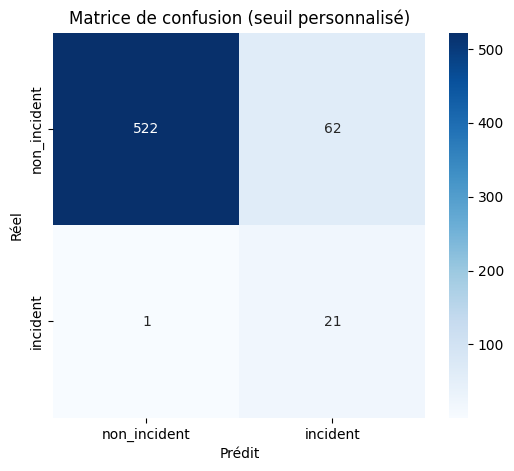

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("\n📋 Rapport de classification avec seuil personnalisé :")
print(classification_report(y_true, y_pred, target_names=["non_incident", "incident"]))

# 🔲 Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["non_incident", "incident"],
            yticklabels=["non_incident", "incident"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion (seuil personnalisé)")
plt.show()

In [ ]:
# 🔍 Affiche un faux négatif (si présent)
if false_negatives:
    print("\n🔎 Exemple de faux négatif :")
    fn = false_negatives[0]  # Le premier faux négatif
    for key, value in fn.items():
        print(f"{key}: {value}")
else:
    print("\n✅ Aucun faux négatif détecté.")


🔎 Exemple de faux négatif :
index: 383
proba_incident: 0.31584951281547546
text: ac: bonjour j’ai un souci le vsl sui devait venir est tolbe rn panne sur a86 je ne pourrai effectuer le transport cordialement paramedic: Nous Recommandons un transport ac: merci
trip_type: PIA externe (SSR vers MCO)
ambulance_company: Ambulances Clichy
time_type: Prise en charge
is_weekend: False
is_bank_holidays: False
dt_starting: 2025-07-01 07:45:00
first_message_dt: 2025-07-01 07:42:26
latest_message_dt: 2025-07-01 07:54:37
